In [1]:
import torch
from transformers import ViTFeatureExtractor, ViTImageProcessor, ViTModel
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
from transformers import CLIPProcessor, CLIPModel

In [10]:
# Step 1: Initialize the feature extractor and the model
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_type = 'vit'
if model_type == 'vit':
    model_id = 'google/vit-base-patch16-224'
    feature_extractor = ViTImageProcessor.from_pretrained(model_id)
    model = ViTModel.from_pretrained(model_id).to(device)
if model_type == 'clip':
    # if using CLIP
    model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def main(image_path, text=['indoor', 'outdoor'], model_type='vit', require_attention=True, layer_idx='all'):
    # Step 2: Load the image
    # url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
    # image = Image.open(requests.get(url, stream=True).raw)
    # 'samples/images_from_merge00aaca6bc1f45ae0628a2c702d48/0001.jpg'
    image = Image.open(image_path)
    # Step 3: Preprocess the image and prepare for the model
    if model_type == 'vit':
        require_attention = require_attention
        inputs = feature_extractor(images=image, return_tensors="pt").to(device)
        # Step 4: Forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True )
            if require_attention:
                # Step 5: Extract attention weights and reshape to get the attention heatmap
                if layer_idx == 'all':
                    attention_heatmap = outputs.attentions.squeeze(0).mean(0) 
                else:
                    attention_heatmap = outputs.attentions[layer_idx].squeeze(0).mean(0) 
                # Take the attention for the class token ([CLS]) with all the patches
                attention_heatmap = attention_heatmap[0, 1:].reshape((14, 14)).detach()
                
                # Step 6: Resize the attention heatmap to the size of the image and normalize it
                attention_heatmap = attention_heatmap / torch.max(attention_heatmap)
                attention_heatmap = np.array(Image.fromarray(attention_heatmap.detach().cpu().numpy()).resize(image.size, Image.BILINEAR))
            
    if model_type == 'clip':
        inputs = processor(text=text, images=image, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image # this is the image-text similarity score
            probs = logits_per_image.softmax(dim=1).squeeze(0).detach().cpu().numpy()
        for i, prob in enumerate(probs):
            print(f'{text[i]} ---> {prob*100:.2f}%')
    
    
    # Step 7: Overlay the heatmap on the original image
    plt.imshow(image)
    if require_attention and model_type=='vit':
        plt.imshow(attention_heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap
    plt.axis('off')  # Hide the axes
    plt.show()

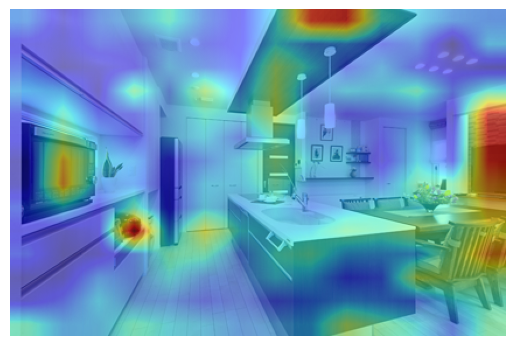

In [12]:
if __name__ == '__main__':
    # 'samples/images_from_merge/00aaca6bc1f45ae0628a2c702d48/0002.jpg'
    main('2022年度_修論引継資料_下村隼生/子育て世帯向け住宅の供給側分析/内観特徴分析/scraping_images/A_大和ハウス工業/no_human/A_20_8.jpg',
         text=['bright room', 'wooden interior ', 'dark room', 'family friendly', 'model building outlook'],
         model_type=model_type, layer_idx=3
        )